## Classification using siamese model

In [1]:
import keras

Using TensorFlow backend.


In [2]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [3]:
from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Model

## Configurações Globais

In [5]:
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

In [6]:
DOMAIN = 'eclipse'
METHOD = 'baseline_dwen'
DIR = 'data/processed/{}'.format(DOMAIN)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
SAVE_PATH = '{}_classification({})'.format(METHOD, DOMAIN)
PRETRAINED_MODEL = 'modelos/model_{}_feature_100epochs_64batch({}).h5'.format(METHOD, DOMAIN)

In [7]:
import keras
from keras.models import Model
from keras.layers import Input
from keras.models import load_model
import keras.backend as K

K.clear_session()

"""
    A lista de modelos estar disponível no diretorio /modelos
        name:
            - model_baseline_{X}epoch_{Y}steps_({dataset}).h5
            - model_baseline_{X}epoch_{Y}steps_({dataset}).json
    
        Informações adicionais:
            {X} - total de épocas treinada. Ex: 100, 1000
            {Y} - total de steps validados no treino. Ex: 10, 16
            {dataset} - Nome da base testada. Ex: Eclipse, Netbeans, OpenOffice
"""
similarity_model = load_model(PRETRAINED_MODEL)

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
import keras.backend as K

MAX_SEQUENCE_LENGTH_T = K.int_shape(similarity_model.input[0])[1]
MAX_SEQUENCE_LENGTH_D = K.int_shape(similarity_model.input[1])[1]

MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D

(20, 100)

In [9]:
baseline = Baseline(DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [10]:
baseline.info_dict

{'bug_severity': 7,
 'bug_status': 3,
 'component': 927,
 'priority': 5,
 'product': 189,
 'version': 551}

In [11]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

Creating the buckets...


#### Loading bug ids in memory

In [12]:
experiment.load_ids()
len(baseline.bug_ids)

Reading bug ids


361006

#### Loading train bugs

In [13]:
%%time

experiment.load_bugs()


CPU times: user 45.9 s, sys: 2.78 s, total: 48.7 s
Wall time: 48.6 s


In [14]:
%%time
issues_by_buckets = experiment.get_buckets_for_bugs()
experiment.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')


Reading train data
Reading bug ids
CPU times: user 2min 49s, sys: 98.7 ms, total: 2min 49s
Wall time: 2min 49s


In [15]:
%%time

bug_train_ids = experiment.get_train_ids(baseline.train_data)
len(bug_train_ids)

CPU times: user 23.1 ms, sys: 0 ns, total: 23.1 ms
Wall time: 22.7 ms


In [16]:
%%time

baseline.test_data, baseline.dup_sets_test = experiment.read_test_data_classification(DIR, baseline.bug_set, 
                                                                                      bug_train_ids, 
                                                                                      path='test_chronological')

Reading test data for classification
CPU times: user 23.8 s, sys: 4.11 ms, total: 23.8 s
Wall time: 23.8 s


## Siamese  model

In [17]:
# Freeze weights
for layer in similarity_model.layers:
    layer.trainable = False

In [18]:
from keras.layers import concatenate, Dropout, Add

bug_t_a_input = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_a')
bug_t_b_input = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_b')

bug_d_a_input = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_a')
bug_d_b_input = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_b')
    
title_embed = similarity_model.get_layer('embedding_layer_title')
desc_embed = similarity_model.get_layer('embedding_layer_desc')
title_encoder = similarity_model.get_layer('global_average_pooling1d_1')
desc_encoder = similarity_model.get_layer('global_average_pooling1d_2')

# Bug A
bug_t_a_embed = title_embed(bug_t_a_input)
bug_d_a_embed = desc_embed(bug_d_a_input)
# Bug B
bug_t_b_embed = title_embed(bug_t_b_input)
bug_d_b_embed = desc_embed(bug_d_b_input)

# Bug A
bug_t_a = title_encoder(bug_t_a_embed)
bug_d_a = desc_encoder(bug_d_a_embed)
# Bug B
bug_t_b = title_encoder(bug_t_b_embed)
bug_d_b = desc_encoder(bug_d_b_embed)

model = similarity_model.get_layer('merge_features_dwen_a')

bug_a = model([bug_t_a, bug_d_a])
bug_b = model([bug_t_b, bug_d_b])

x = concatenate([bug_a, bug_b], name='bugs') # 

for _ in range(2):
    x = Dense(128)(x)
    x = Dropout(0.75)(x)
    x = Activation('tanh')(x)
    # x = BatchNormalization()(x)

output = Dense(2, activation = 'softmax', name = 'output')(x)

model_clf = Model(inputs=[bug_t_a_input, bug_t_b_input, bug_d_a_input, bug_d_b_input], outputs=[output])

#adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

model_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model_clf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_a (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
desc_a (InputLayer)             (None, 100)          0                                            
__________________________________________________________________________________________________
title_b (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
desc_b (InputLayer)             (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_

In [19]:
bug_train_ids = experiment.get_train_ids(baseline.train_data)

In [20]:
bug_test_ids = experiment.get_train_ids(baseline.test_data)

In [21]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def batch_classification(train, dup_sets, batch_size, n_neg, bug_ids):
    encoder = LabelEncoder()
    batch_size_normalized = batch_size // 2
    batch_triplet, input_sample, input_pos, input_neg, sim = baseline.batch_iterator(train, dup_sets, bug_ids, 
                                                                                     batch_size_normalized, n_neg)
    
    pos = np.full((1, batch_size_normalized), 1)
    neg = np.full((1, batch_size_normalized), 0)
    sim = np.concatenate([pos, neg], -1)[0]
    
    sim = encoder.fit_transform(sim)
    sim = to_categorical(sim)

    title_a = np.concatenate([input_sample['title'], input_sample['title']])
    title_b = np.concatenate([input_pos['title'], input_neg['title']])
    desc_a = np.concatenate([input_sample['description'], input_sample['description']])
    desc_b = np.concatenate([input_pos['description'], input_neg['description']])
    info_a = np.concatenate([input_sample['info'], input_sample['info']])
    info_b = np.concatenate([input_pos['info'], input_neg['info']])
    
    return title_a, title_b, desc_a, desc_b, info_a, info_b, sim

def batch_classification_siamese(train, dup_sets, batch_size, n_neg, bug_ids):
    while True:
        title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(train, dup_sets, batch_size, 
                                                                                     n_neg, bug_ids)
        
        yield ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [22]:
title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train,
                                                                             512, 1, bug_train_ids)
test_validation = ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [23]:
%%time

early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')

h_clf = model_clf.fit_generator(batch_classification_siamese(baseline.train_data, baseline.dup_sets_train, 1024, 
                                                             1, bug_train_ids), 
                               steps_per_epoch = 10,
                               validation_data=test_validation,
                                             epochs = 100,
#                                              callbacks=[early],
                                             verbose = True) 

Epoch 1/100
10/10 [==============================] - 1s 103ms/step - loss: 0.7379 - acc: 0.5093 - val_loss: 0.7003 - val_acc: 0.5000
Epoch 2/100
10/10 [==============================] - 1s 75ms/step - loss: 0.7397 - acc: 0.4959 - val_loss: 0.6922 - val_acc: 0.5039
Epoch 3/100
10/10 [==============================] - 1s 81ms/step - loss: 0.7285 - acc: 0.5133 - val_loss: 0.6970 - val_acc: 0.5234
Epoch 4/100
10/10 [==============================] - 1s 82ms/step - loss: 0.7277 - acc: 0.5040 - val_loss: 0.6940 - val_acc: 0.5059
Epoch 5/100
10/10 [==============================] - 1s 78ms/step - loss: 0.7181 - acc: 0.5057 - val_loss: 0.6969 - val_acc: 0.5156
Epoch 6/100
10/10 [==============================] - 1s 84ms/step - loss: 0.7205 - acc: 0.4983 - val_loss: 0.6916 - val_acc: 0.5078
Epoch 7/100
10/10 [==============================] - 1s 85ms/step - loss: 0.7090 - acc: 0.5119 - val_loss: 0.6946 - val_acc: 0.5312
Epoch 8/100
10/10 [==============================] - 1s 82ms/step - loss: 0

10/10 [==============================] - 1s 86ms/step - loss: 0.6847 - acc: 0.5520 - val_loss: 0.7211 - val_acc: 0.5332
Epoch 63/100
10/10 [==============================] - 1s 85ms/step - loss: 0.6862 - acc: 0.5493 - val_loss: 0.7109 - val_acc: 0.5312
Epoch 64/100
10/10 [==============================] - 1s 83ms/step - loss: 0.6867 - acc: 0.5483 - val_loss: 0.7135 - val_acc: 0.5234
Epoch 65/100
10/10 [==============================] - 1s 94ms/step - loss: 0.6838 - acc: 0.5571 - val_loss: 0.7142 - val_acc: 0.5293
Epoch 66/100
10/10 [==============================] - 1s 86ms/step - loss: 0.6818 - acc: 0.5692 - val_loss: 0.7188 - val_acc: 0.5410
Epoch 67/100
10/10 [==============================] - 1s 84ms/step - loss: 0.6838 - acc: 0.5589 - val_loss: 0.7234 - val_acc: 0.5469
Epoch 68/100
10/10 [==============================] - 1s 81ms/step - loss: 0.6835 - acc: 0.5599 - val_loss: 0.7187 - val_acc: 0.5410
Epoch 69/100
10/10 [==============================] - 1s 79ms/step - loss: 0.6840 

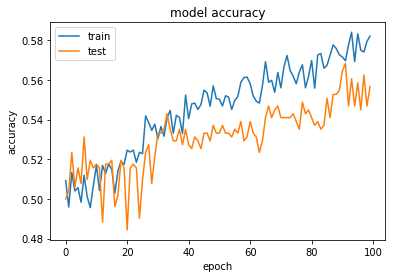

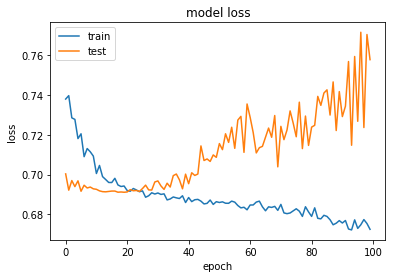

In [24]:
Baseline.validation_accuracy_loss(h_clf)

### Accuracy

In [25]:
result = { }

#### train

In [26]:
from sklearn.metrics import accuracy_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, 512, 1, 
                                                                             bug_train_ids)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
acc_train = accuracy_score(y_true, y_scores)
acc_train

0.541015625

#### test

In [27]:
from sklearn.metrics import accuracy_score

number_of_pairs = len(baseline.test_data)

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.test_data, 
                                                                             baseline.dup_sets_test, 
                                                                             number_of_pairs, 1, bug_test_ids)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
acc_test = accuracy_score(y_true, y_scores)
acc_test

0.571551724137931

### Roc AUC/SCORE

#### train

In [28]:
from sklearn.metrics import roc_auc_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, 512, 1, bug_train_ids)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

roc_train = roc_auc_score(y_true, y_scores)
roc_train

0.6168212890625

#### test

In [29]:
from sklearn.metrics import roc_auc_score

number_of_pairs = len(baseline.test_data)

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.test_data, 
                                                                             baseline.dup_sets_test, 
                                                                             number_of_pairs, 1, bug_test_ids)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

roc_test = roc_auc_score(y_true, y_scores)
roc_test

0.8115508416319858

#### Save the model

In [30]:
experiment.save_model(model_clf, SAVE_PATH)

#### Saving the accuracy and roc/auc

In [31]:
import _pickle as pickle

CLASSIFICATION_PATH = 'classification_{}.pkl'.format(METHOD)

def save_result(result):
    result = {
        'acc_train' : acc_train,
        'acc_test' : acc_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
        'method' : METHOD
    }

    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'wb') as f:
        pickle.dump(result, f)

try:
    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'rb') as f:
        result = pickle.load(f)
    save_result(result)
except:
    save_result(result)
    
print("All saved.")

All saved.
